# **\[Essays\]** 강화학습 v5

신록예찬  
2023-08-12

# imports

In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython
import random

# 기존알고리즘

In [25]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,env):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.buffer_size = 10000 
        self.batch_size = 128
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.eps = 0

        # Q-Network
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.state_size,128), 
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,self.action_size)) # 4는 action_size 
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)

        # ReplayBuffer
        self.memory = collections.deque(maxlen=self.buffer_size)

    def __rshift__(self,env):
        if np.random.rand() > self.eps:
            self.action = self.net(torch.tensor(self.current_state)).argmax().item()
        else:
            self.action = random.choice(np.arange(self.action_size))
        env.received_action = self.action 

    def __lshift__(self,env): 
        self.next_state, self.reward, self.terminated, _, _ = env.step(env.received_action)
        self.add()
        
    def add(self):
        """Add a new experience to memory."""
        Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        experience = Experience(self.current_state, self.action, self.reward, self.next_state, self.terminated)
        self.memory.append(experience)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        self.S = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        self.A = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        self.R = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        self.Sprime = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        # Convert done from boolean to int
        self.T = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
    def step(self):
        self.current_state = self.next_state 
        self.score += self.reward

    def learn(self):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        self.sample()

        ## Compute and minimize the loss
        q_targets_next = self.net(self.Sprime).detach().max(1)[0].unsqueeze(1)
        q_targets = self.R + 0.99 * q_targets_next * (1 - self.T)

        ### Calculate expected value from local network
        q_expected = self.net(self.S).gather(1, self.A)
        
        loss = torch.nn.functional.mse_loss(q_expected, q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def reset(self,env): 
        self.current_state, _ = env.reset()
        self.score = 0 

In [26]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [27]:
agent = Agent(env)

In [28]:
n_episodes = 2000
max_t = 500
eps_start = 1.0 
eps_end = 0.01
eps_decay = 0.995

playtimes=[] 
scores = []                        # list containing scores from each episode
scores_window = collections.deque(maxlen=100)  # last 100 scores
agent.eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    agent.reset(env) 
    for t in range(max_t):
        agent >> env 
        agent << env 
        if len(agent.memory) > agent.batch_size:
            agent.learn()
        agent.step()
        if agent.terminated:
            playtimes.append(t)
            break 
    scores_window.append(agent.score)
    scores.append(agent.score)
    agent.eps = max(eps_end, eps_decay*agent.eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
        break

Episode 100 Average Score: -137.87  Playtime: 110.91
Episode 200 Average Score: -47.68   Playtime: 141.455
Episode 300 Average Score: 86.37    Playtime: 153.571
Episode 400 Average Score: 180.53   Playtime: 187.18
Episode 421 Average Score: 201.12   Playtime: 196.85
Environment solved in 421 episodes! Average Score: 201.12

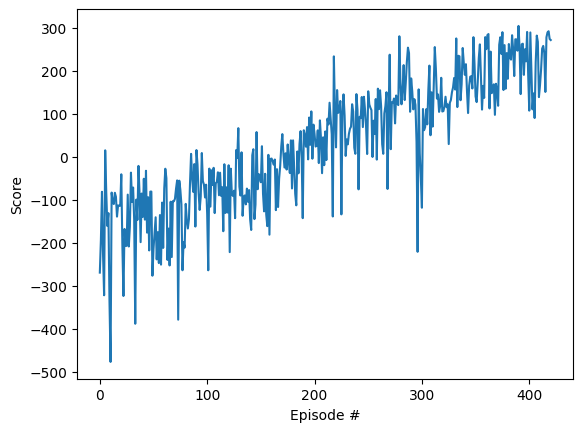

In [29]:
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

In [31]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')
frames = []
agent = Agent(env)
agent.net.load_state_dict(torch.load('checkpoint.pth'))
agent.reset(env)
agent.terminated = False

while not agent.terminated:
    frames.append(env.render())
    agent >> env 
    agent << env 
    agent.step()

env.close()

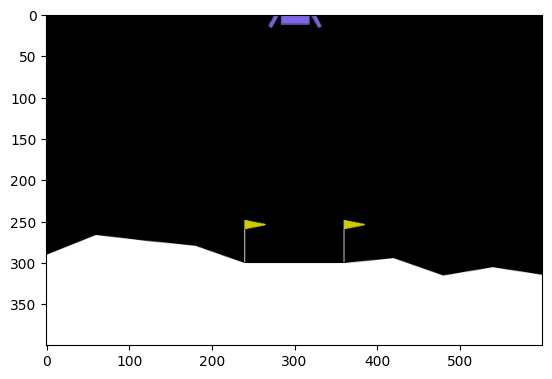

In [32]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::10][i]),frames=len(frames[::10]))

`-` 방법1

In [33]:
# ani.save('LunarLander-v2.mp4', writer='ffmpeg', fps=15, extra_args=['-vcodec', 'mpeg4'])

`-` 방법2

In [34]:
IPython.display.HTML(ani.to_jshtml())